# Training ViT

In [1]:
import torch 
import torch.nn as nn

from src.data.dataset import get_dataloader

import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
SEED = 0

BATCH_SIZE = 64
LR = 1e-4
NUM_EPOCHES = 20

In [4]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Preprocessing

In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
train_loader, val_loader, test_loader = get_dataloader("./data/CIFAR10/", BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [7]:
from src.models.model import ViT

In [8]:
image_size = 32
channel_size = 3
patch_size = 8
embed_size = 512
num_heads = 8
classes = 10
num_layers = 2
hidden_size = 256
dropout = 0.3

model = ViT(image_size, channel_size, patch_size, embed_size, num_heads, classes, num_layers, hidden_size, dropout=dropout).to(DEVICE)
model

ViT(
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (embeddings): Linear(in_features=192, out_features=512, bias=True)
  (encoders): ModuleList(
    (0): VisionEncoder(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.3, inplace=False)
        (Q): Linear(in_features=512, out_features=512, bias=True)
        (K): Linear(in_features=512, out_features=512, bias=True)
        (V): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU()
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
    (1): VisionEncoder(
      (norm1): 

In [9]:
for img, label in train_loader:
    img = img.to(DEVICE)
    label = label.to(DEVICE)
    
    print("Input Image Dimensions: {}".format(img.size()))
    print("Label Dimensions: {}".format(label.size()))
    print("-"*100)
    
    out = model(img)
    
    print("Output Dimensions: {}".format(out.size()))
    break

Input Image Dimensions: torch.Size([64, 3, 32, 32])
Label Dimensions: torch.Size([64])
----------------------------------------------------------------------------------------------------
Output Dimensions: torch.Size([64, 10])


## Training

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [11]:
loss_hist = {"train accuracy": [], "train loss": [], "val accuracy": []}

for epoch in range(1, NUM_EPOCHES+1):
    model.train()
    
    epoch_train_loss = 0
        
    y_true_train = []
    y_pred_train = []
        
    for batch_idx, (img, labels) in enumerate(train_loader):
        img = img.to(DEVICE)
        labels = labels.to(DEVICE)
        
        preds = model(img)
        
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_train.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())
            
        epoch_train_loss += loss.item()

    with torch.no_grad():
        model.eval()

        y_true_test = []
        y_pred_test = []

        for batch_idx, (img, labels) in enumerate(val_loader):
            img = img.to(DEVICE)
            labels = labels.to(DEVICE)

            preds = model(img)

            y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
            y_true_test.extend(labels.detach().tolist())

            test_total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
            test_total = len(y_pred_test)
            test_accuracy = test_total_correct * 100 / test_total
    
    loss_hist["train loss"].append(epoch_train_loss)

    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    
    loss_hist["train accuracy"].append(accuracy)
    loss_hist["val accuracy"].append(test_accuracy)
    
    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, epoch_train_loss))
    print("       Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("       Validation Accuracy%: ", test_accuracy, "==", test_total_correct, "/", test_total)
    print("-------------------------------------------------")

-------------------------------------------------
Epoch: 1 Train mean loss: 1501.48105025
       Train Accuracy%:  29.666 == 14833 / 50000
       Validation Accuracy%:  41.66 == 2083 / 5000
-------------------------------------------------
-------------------------------------------------
Epoch: 2 Train mean loss: 1299.27744937
       Train Accuracy%:  39.834 == 19917 / 50000
       Validation Accuracy%:  46.42 == 2321 / 5000
-------------------------------------------------
-------------------------------------------------
Epoch: 3 Train mean loss: 1232.41453695
       Train Accuracy%:  42.854 == 21427 / 50000
       Validation Accuracy%:  49.62 == 2481 / 5000
-------------------------------------------------
-------------------------------------------------
Epoch: 4 Train mean loss: 1189.31977367
       Train Accuracy%:  45.034 == 22517 / 50000
       Validation Accuracy%:  50.3 == 2515 / 5000
-------------------------------------------------
-----------------------------------------

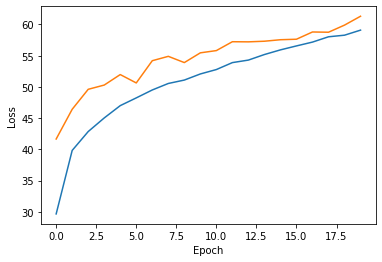

In [12]:
plt.plot(loss_hist["train accuracy"])
plt.plot(loss_hist["val accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

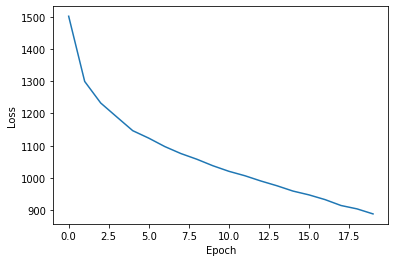

In [13]:
plt.plot(loss_hist["train loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Testing

In [14]:
with torch.no_grad():
    model.eval()
    
    y_true_test = []
    y_pred_test = []
    
    for batch_idx, (img, labels) in enumerate(test_loader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
    
        preds = model(img)
        
        y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_test.extend(labels.detach().tolist())
        
    total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
    total = len(y_pred_test)
    accuracy = total_correct * 100 / total
    
    print("Test Accuracy%: ", accuracy, "==", total_correct, "/", total)

Test Accuracy%:  59.36 == 2968 / 5000


## Saving Model Weights 

In [15]:
torch.save(model.state_dict(), "./trained_models/vit_cifar10.pt")